In [1]:
import numpy as np
import pandas as pd
import matplotlib as plt
from obspy import read
from obspy.core import UTCDateTime
from obspy.core.stream import Stream

In [2]:
min_filtering_frequency = 0.1
max_filtering_frequency = 30

root_folder = "data20180703ext"
ud01_data_folder_path = root_folder+"/UD01"
ud02_data_folder_path = root_folder+"/UD02"
ud03_data_folder_path = root_folder+"/UD03"
ud04_data_folder_path = root_folder+"/UD04"

directions_data_folders = ["6d97e2", "6d97n2", "6d97z2"]

In [3]:
def process_station_data(station_data_folder):
    import os 
    station_data = Stream()
    for direction in directions_data_folders:
        direction_stream = Stream()
        data_folder = station_data_folder+"/"+direction
        for filename in os.listdir(data_folder):
            direction_stream+=read(data_folder+"/"+filename)
        direction_stream.merge(fill_value=0)
        station_data+=direction_stream
    return station_data

1. UDINA_год_месяц_день_час_минута_секунда

In [4]:
class SeismicData():
    def __init__(self, station_data):
        self.__station_data_preprocessing(station_data)
        self.alive_traces_with_times = []
        self.alive_traces_count = []
    def calculate_live_traces(self):
        print('Calculating number of alive traces...')
        for cur_index, time in enumerate(self.times):
            alive_traces = 0
            for trace in self.traces:
                if trace.data[cur_index] != 0:
                    alive_traces+=1
            self.alive_traces_with_times.append((time, alive_traces))
        for alive_trace in self.alive_traces_with_times:
            self.alive_traces_count.append(alive_trace[1])
        print('Calculating number of alive traces finished')
    def plot_station_data(self):
        self.__station_data.plot()
    def convert_to_csv(self, file_name="seismic_data.csv"):
        print('Converting object to matrix...')
        self.calculate_live_traces()
        all_data = []
        for trace in self.traces:
            print(trace)
            all_data.append(trace.data)
        all_data.append(self.times)
        all_data.append(self.alive_traces_count)
        df = pd.DataFrame([np.array(all_data)])
        df.to_csv(file_name)
        print('Converting object to matrix finished')
    def __trace_preprocessing(self, target_trace, canonical_times, npts):
        print('Trace preprocessing...')
        target_times = target_trace.times('utcdatetime')
        if(len(target_times) < len(canonical_times)):
            target_trace.stats.starttime = canonical_times[0]
            target_trace.stats.npts = npts
            indexes = len(canonical_times) - len(target_times)
            zeros = np.zeros([indexes])
            new = np.hstack([zeros,target_trace.data])
            target_trace.data = new
        print('Trace preprocessing finished')
    
    def __station_data_preprocessing(self, station_data):
        print('Station data preprocessing...')
        max_trace = None
        max_len = 0
        for trace in station_data.traces:
            if len(trace.data) > max_len:
                max_len = len(trace.data)
                max_trace = trace
        print('max trace = {0}'.format(max_trace))
        max_times = max_trace.times('utcdatetime')
        print('max trace times = {0}'.format(max_times))
        for trace in station_data.traces:
            self.__trace_preprocessing(trace, max_times, max_trace.stats.npts)
        
        self.__station_data = station_data
        self.traces = station_data.traces
        self.times = station_data[0].times('utcdatetime')
        self.starttime = self.times[0]
        self.endtime = self.times[len(self.times)-1]
        
        print('Station data preprocessing finished')

In [5]:
station_data = process_station_data(ud01_data_folder_path)
station_data += process_station_data(ud02_data_folder_path)
station_data += process_station_data(ud03_data_folder_path)
station_data += process_station_data(ud04_data_folder_path)

In [6]:
seismic_data = SeismicData(station_data)


Station data preprocessing...
max trace = .6D97..HHE | 2018-07-03T00:00:00.000000Z - 2018-07-04T05:59:59.990000Z | 100.0 Hz, 10800000 samples
max trace times = [UTCDateTime(2018, 7, 3, 0, 0) UTCDateTime(2018, 7, 3, 0, 0, 0, 10000)
 UTCDateTime(2018, 7, 3, 0, 0, 0, 20000) ...
 UTCDateTime(2018, 7, 4, 5, 59, 59, 970000)
 UTCDateTime(2018, 7, 4, 5, 59, 59, 980000)
 UTCDateTime(2018, 7, 4, 5, 59, 59, 990000)]
Trace preprocessing...
Trace preprocessing finished
Trace preprocessing...
Trace preprocessing finished
Trace preprocessing...
Trace preprocessing finished
Trace preprocessing...
Trace preprocessing finished
Trace preprocessing...
Trace preprocessing finished
Trace preprocessing...
Trace preprocessing finished
Trace preprocessing...
Trace preprocessing finished
Trace preprocessing...
Trace preprocessing finished
Trace preprocessing...
Trace preprocessing finished
Trace preprocessing...
Trace preprocessing finished
Trace preprocessing...
Trace preprocessing finished
Trace preprocessing

1. берём каждое значение амплитуды в каждый момент времени
2. суммируем в квадрате все эти значения
3. ищем среднеем (делим на кол-во живых трасс)
4. строим график. 
5. далее для триггирования нужно будет определить некий эпсилон (т.е. понять уровень, начиная с которого будем считать, что произошло событие) и интервал т1-т2 - сколько отступить назад\вперёд) 
6. интервал нужен для того, чтобы потом по всем сигналам вытаскивать куски сигнала вместе с шумом до начал события, сао событие и то, что происходило после.
7. в итоговой структуре ряд с датами перевести в секундное представление
8. отрисовать итоговой ряд после получения осреднённых значений


1. у суммирования есть ещё один параметр m - длина сглаживания
2. S_i = (s_(i-m/2) + ... + s_(i+m/2))/m - вот этот ряд нас интересует. Подробнее на листочке. 
3. сделать к четвергу

In [7]:
def square_sum (seismic_data):
    square_sum = list()
    for i, time in enumerate(seismic_data.times):
        summ = np.int64(0)
        for trace in seismic_data.traces:
            summ+=trace[i]*trace[i]
        summ /= seismic_data.alive_traces_count[i]
        square_sum.append((time, summ))
    return square_sum


In [11]:
seismic_data.calculate_live_traces()
squareSum = square_sum(seismic_data)
x = list()
y = list()

for item in squareSum:
    x.append(item[0])
    y.append(item[1])

Calculating number of alive traces...
Calculating number of alive traces finished


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in long_scalars
  


In [9]:
def moving_average(a, n):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

x_copy=10800000
y_copy=10800000


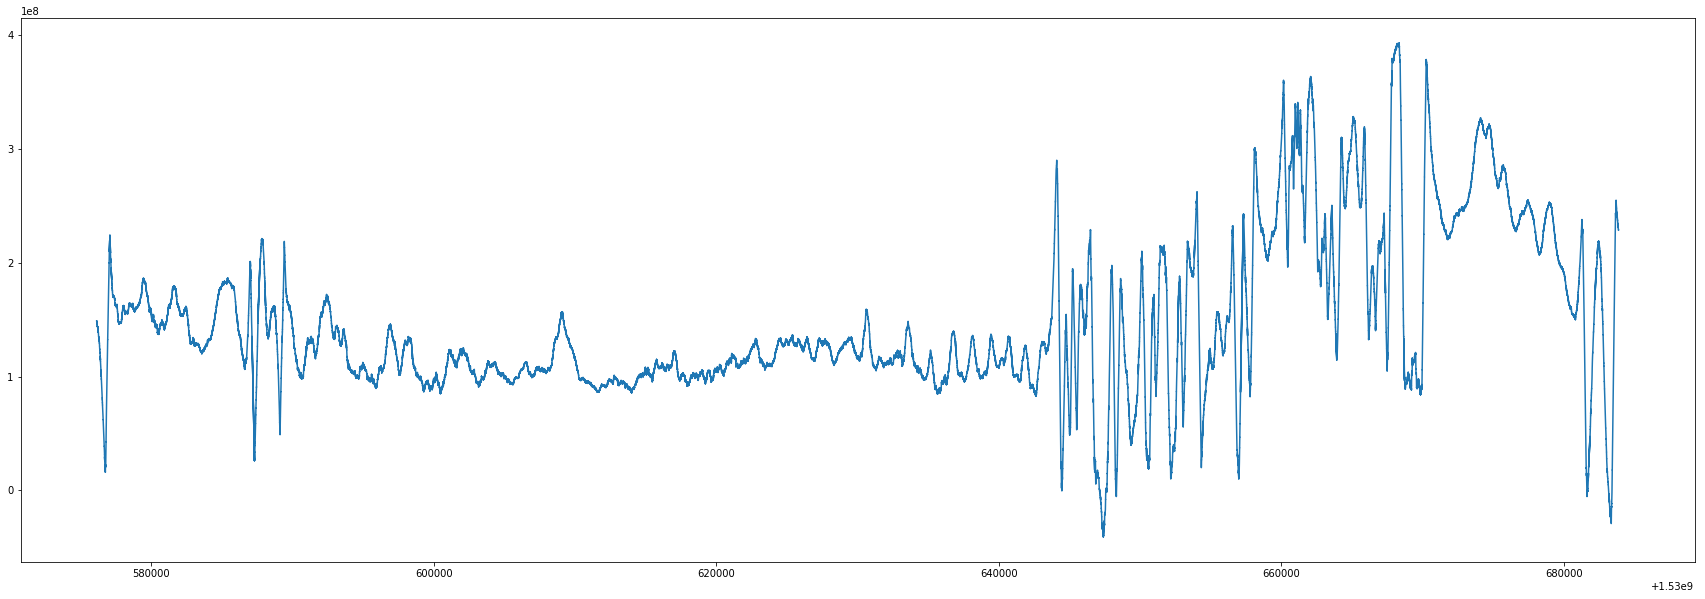

In [16]:
m = 30000
x_copy = x.copy()
y_copy = y.copy()
print('x_copy={0}'.format(len(x_copy)))
print('y_copy={0}'.format(len(y_copy)))
x_copy = moving_average(x_copy, m)
y_copy = moving_average(y_copy, m)
from matplotlib import pyplot as plt
plt.figure(figsize=(30,10))
plt.plot(x_copy,y_copy)
plt.show()